<a href="https://colab.research.google.com/github/aleena999/wbc_deepLearning/blob/main/VGG16_WBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
!wget --no-check-certificate \
    "https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip" \
    -O "/tmp/WBC_images.zip"


zip_ref = zipfile.ZipFile('/tmp/WBC_images.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-05-26 19:27:43--  https://github.com/kittiekat/WBC_Classifier/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main [following]
--2022-05-26 19:27:43--  https://codeload.github.com/kittiekat/WBC_Classifier/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/WBC_images.zip’

/tmp/WBC_images.zip     [    <=>             ]   1010M  19.1MB/s    in 45s     

2022-05-26 19:28:29 (22.2 MB/s) - ‘/tmp/WBC_images.zip’ saved [1059522558]



#Headers
NumPy for computation

plotly.express, matplotlib.pyplot, seaborn for visualization

tesnflow for training

sklearn.metrics for analyzing reports



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.applications.vgg16 import VGG16

In [ ]:
# Loading Dataset

train_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Train'
test_dir = '/tmp/WBC_Classifier-main/images/Rabin Data/Test'

#Loading Image Data
Generators will load them few at a time, train on them and recycle memory.

**tf.keras.preprocessing.image.ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation

**preprocessing_function:** The function will run after the image is resized and augmented. The function should take one argument: one image (Numpy tensor with rank 3), and should output a Numpy tensor with the same shape.

**validation_split:** Fraction of images reserved for validation (strictly between 0 and 1)

In [ ]:
# Create generators
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Flow image data

train_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_gen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.
Found 4339 images belonging to 5 classes.


#Build Pretrained Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten
vgg=VGG16(include_top=False,weights='imagenet',
         input_shape=(224, 224, 3))

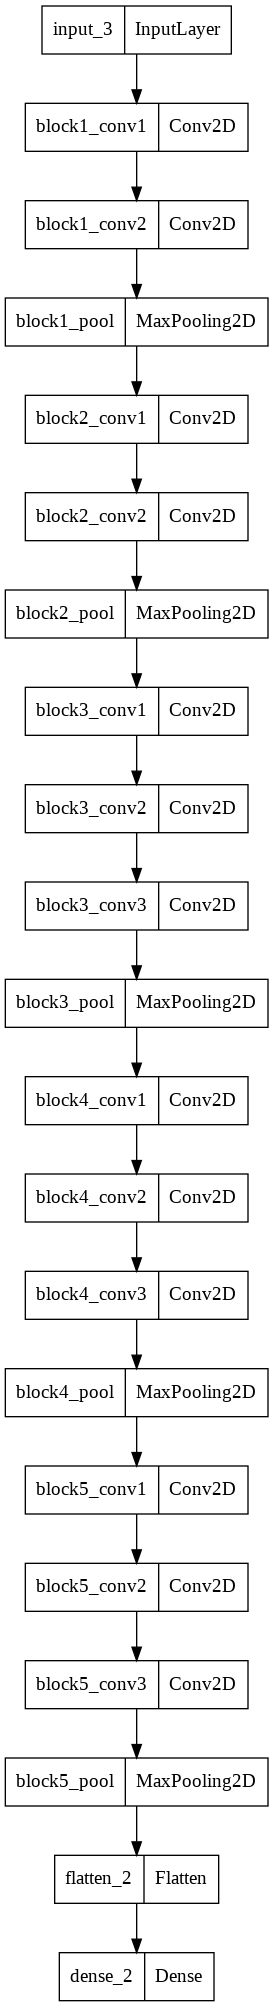

In [ ]:
for layer in vgg.layers:
  layer.trainable=False
x=Flatten()(vgg.output)
prediction_vgg=tf.keras.layers.Dense(5,activation='sigmoid')(x)
##Create Inception Model
from tensorflow.keras.models import Model
vgg_model=Model(inputs=vgg.input,outputs=prediction_vgg)
plot_model(vgg_model)

In [ ]:
from tensorflow.keras.optimizers import RMSprop
vgg_model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
vgg_history=vgg_model.fit(train_images,
                          validation_data=val_images,
                          steps_per_epoch=100,
                         epochs = 25,
                          callbacks=[
                                     tf.keras.callbacks.EarlyStopping(
                                         monitor='val_loss',
                                         patience=3,
                                         restore_best_weights=True)
    ],
                          verbose=1)

Epoch 1/25
100/100 [==============================] - 2626s 26s/step - loss: 1.1149 - accuracy: 0.7187 - val_loss: 0.5145 - val_accuracy: 0.8052
Epoch 2/25
100/100 [==============================] - 2615s 26s/step - loss: 0.3967 - accuracy: 0.8746 - val_loss: 0.4827 - val_accuracy: 0.8544
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9199 

#Build Classification Model

#Training

In [ ]:
fig = px.line(
    vgg_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

#Results

In [ ]:
CLASS_NAMES = list(train_images.class_indices.keys())
CLASS_NAMES

In [ ]:
predictions = np.argmax(vgg_model.predict(test_images), axis=1)

acc = accuracy_score(test_images.labels, predictions)
cm = tf.math.confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=CLASS_NAMES)

print("Test Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

In [ ]:
val_images = train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset='validation'
)


predictions = np.argmax(vgg_model.predict(val_images), axis=1)

acc = accuracy_score(val_images.labels, predictions)
cm = tf.math.confusion_matrix(val_images.labels, predictions)
clr = classification_report(val_images.labels, predictions, target_names=CLASS_NAMES)

print("Validation Accuracy: {:.3f}%".format(acc * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.yticks(ticks= np.arange(4) + 0.5, labels=CLASS_NAMES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)